In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls 'drive/My Drive/Colab Notebooks'

 AttentionModel.ipynb		   shuffled-full-set-hashed.csv
'baseline result on testdata'	   testdata
 color_tensorflow_real_mode.h5	   Test_q2.xlsx
 HMM_Classification.ipynb	   Train_q2.xlsx
 images				   Untitled0.ipynb
 LSTM_Classifcation.ipynb	   Untitled1.ipynb
 lstm_classification_keras.ipynb   Untitled2.ipynb
 model.json			   Untitled3.ipynb
 model.pkl			   Untitled4.ipynb
 Opencountry			   Untitled5.ipynb
 Sampling.ipynb


In [0]:
cd 'drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


#### Let's load all the important packages

In [0]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

#### Loading the model file and giving headers to the columns. 

In [0]:
data= pd.read_csv('shuffled-full-set-hashed.csv',header=None)
data.columns = ['Category','Sentences']
display(data.head())


,Category,Sentences
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...


#### Pre-processing the data into words and creating a new column for the length of each document

In [0]:
data['Sentences'] = data['Sentences'].astype(str)
data['Length'] = data['Sentences'].apply(lambda x:len(x.split(' ')))
len(data['Sentences'])

62204

#### We notice that there is a huge class imbalance here and thus in order to get a good data pipeline, we either have to use undersampling/oversampling or stratified sampling on these classes. 

In [0]:
categories_count = data['Category'].value_counts()
print(categories_count)

BILL                       18968
POLICY CHANGE              10627
CANCELLATION NOTICE         9731
BINDER                      8973
DELETION OF INTEREST        4826
REINSTATEMENT NOTICE        4368
DECLARATION                  968
CHANGE ENDORSEMENT           889
RETURNED CHECK               749
EXPIRATION NOTICE            734
NON-RENEWAL NOTICE           624
BILL BINDER                  289
INTENT TO CANCEL NOTICE      229
APPLICATION                  229
Name: Category, dtype: int64


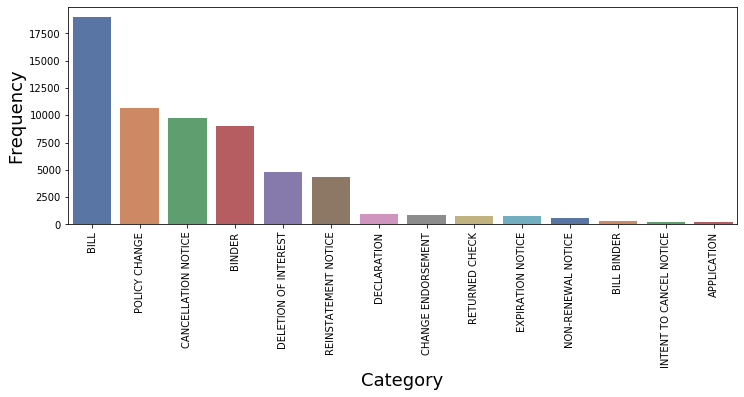

In [0]:
plt.figure(figsize=(12,4))
g = sns.barplot(categories_count.index, categories_count.values,palette="deep", alpha=1)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Category', fontsize=18)
plt.xticks(rotation=90)

plt.show()

# Histogram analysis of the text lenght of each categories.

Applying the function to each sample

In [0]:
data.head(10)

,Category,Sentences,Length
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...,465
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...,403
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...,185
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...,337
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...,546
5,POLICY CHANGE,10e45001c2f2 6a01047db3ab 6a8e3499dab9 97b6014...,536
6,POLICY CHANGE,4e5019f629a9 54fb196d55ce 0cf4049f1c7c ef4ea27...,1059
7,BILL,ad4440ac97a5 8e93a2273a93 c913f5129fe2 bfb030c...,579
8,CANCELLATION NOTICE,25c57acdf805 b7a0f56f6ce8 cf4fc632eed2 67f9c02...,248
9,BILL,48d657cd9861 fee60001e67a 4ce4bfb42e22 de9738e...,574


#### We try to analyse the length distribution of each of the documents and categorize them based on the categories. They all fall around a course normal distribution for each of the categories.

In [0]:
BILL	 = data[data['Category'] == 'BILL']
POLICY_CHANGE	 = data[data['Category'] == 'POLICY CHANGE']
CANCELLATION_NOTICE	 = data[data['Category'] == 'CANCELLATION NOTICE']
BINDER	 = data[data['Category'] == 'BINDER']
DELETION_OF_INTEREST	 = data[data['Category'] == 'DELETION OF INTEREST']
REINSTATEMENT_NOTICE	 = data[data['Category'] == 'REINSTATEMENT NOTICE']
DECLARATION	 = data[data['Category'] == 'DECLARATION']
CHANGE_ENDORSEMENT	 = data[data['Category'] == 'CHANGE ENDORSEMENT']
RETURNED_CHECK	 = data[data['Category'] == 'RETURNED CHECK']
EXPIRATION_NOTICE	 = data[data['Category'] == 'EXPIRATION_NOTICE']
NON_RENEWAL_NOTICE 	 = data[data['Category'] == 'NON-RENEWAL NOTICE']
BILL_BINDER	 = data[data['Category'] == 'BILL BINDER']
APPLICATION	 = data[data['Category'] == 'APPLICATION']
INTENT_TO_CANCEL_NOTICE	 = data[data['Category'] == 'INTENT TO CANCEL NOTICE']

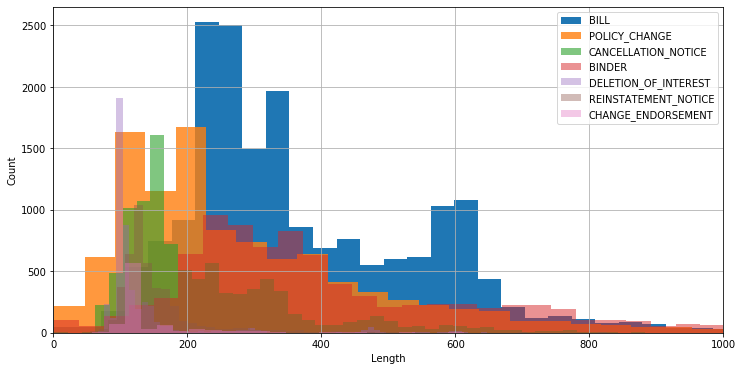

In [0]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 200
plt.hist(BILL['Length'], alpha = 1.0, bins=bins, label='BILL')
plt.hist(POLICY_CHANGE['Length'], alpha = 0.8, bins=bins, label='POLICY_CHANGE')
plt.hist(CANCELLATION_NOTICE['Length'], alpha = 0.6, bins=bins, label='CANCELLATION_NOTICE')
plt.hist(BINDER['Length'], alpha = 0.5, bins=bins, label='BINDER')
plt.hist(DELETION_OF_INTEREST['Length'], alpha = 0.4, bins=bins, label='DELETION_OF_INTEREST')
plt.hist(REINSTATEMENT_NOTICE['Length'], alpha = 0.4, bins=bins, label='REINSTATEMENT_NOTICE')
plt.hist(CHANGE_ENDORSEMENT['Length'], alpha = 0.4, bins=bins, label='CHANGE_ENDORSEMENT')

plt.xlabel('Length')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.xlim(0,1000)
plt.grid()
plt.show()

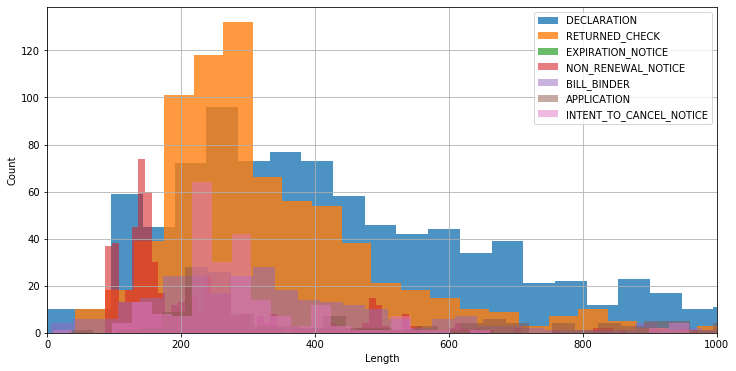

In [0]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 100
plt.hist(DECLARATION['Length'], alpha = 0.8, bins=bins, label='DECLARATION')
plt.hist(RETURNED_CHECK['Length'], alpha = 0.8, bins=bins, label='RETURNED_CHECK')
plt.hist(EXPIRATION_NOTICE['Length'], alpha = 0.7, bins=bins, label='EXPIRATION_NOTICE')
plt.hist(NON_RENEWAL_NOTICE['Length'], alpha = 0.6, bins=bins, label='NON_RENEWAL_NOTICE')
plt.hist(BILL_BINDER['Length'], alpha = 0.5, bins=bins, label='BILL_BINDER')
plt.hist(APPLICATION['Length'], alpha = 0.5, bins=bins, label='APPLICATION')
plt.hist(INTENT_TO_CANCEL_NOTICE['Length'], alpha = 0.5, bins=bins, label='INTENT_TO_CANCEL_NOTICE')

plt.xlabel('Length')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.xlim(0,1000)
plt.grid()
plt.show()

##### We will filter out terms that are very common(present in more than 40% of documents) or scarce and then find the term frquency and document frequency vectorizer. Another option is to use Word2Vec and train the entire model but since the amount of data isn't that much and the number of unique word is quite high, maybe doing TDIDF is a good idea. 

In [0]:
tfidf = TfidfVectorizer(binary=False,decode_error='ignore',sublinear_tf=True, max_df = 0.40, min_df = 0.005, norm='l2',ngram_range=(1, 2))

In [0]:
features = tfidf.fit_transform(data['Sentences'].values).toarray()
import pickle
#store the content 
# Not necessary since we are saving the entire pipeline later on
with open("tfidf_2.pkl", 'wb') as handle:
                    pickle.dump(tfidf, handle)
all_categories = np.unique(data['Category'])
features.shape

(62204, 7787)

In [0]:
data['Sentences'].head(1).values

array(['e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171e2e6d 59260a2781dc ec56ff31bb7a 1cf70e99f986 7d7400d32c11 fbe7c05e32d5 6b0cb5728b14 54709b24b45f 25c57acdf805 8bd6e6f02cbc 31cbd98f4b3c f7548baf29d4 bd0972f16400 1b43925e3c28 b2c878a75d7e 59260a2781dc cf4fc632eed2 25c57acdf805 b4221b1edff9 de9738ee8b24 135307dba198 19e9f3592995 1cf70e99f986 266dc1fd820c b73e657498f2 f1ec22325b37 1fa87d60c46c e4a319284bf9 6b343f522f78 60fb2adbbb87 37428698b32e d03283541bce 59f0408bc81b 9ccf259ca087 54709b24b45f 8bd6e6f02cbc 63198bea516d 7991590bf0b6 2575240863a4 b5ed9af384f4 87b8193a0183 3e5199ae28ae 094e2de7e1cd 422068f04236 25c57acdf805 179dce4734b4 d38820625542 7cd2e94152fb f1413affa34b 288ccf089872 3eba94383fac e1af6790122f f36858486ddc ec3406979928 cff184767152 da9ad7407226 0c222c6660f2 586242498a88 d1c3631d621b 323c2f20cf45 25c57acdf805 2190972b219c f2b0e028fe2c da61efdd2b77 9cdf4a63deb0 6a95ce91efbd 432bd6e0c08f 6b343f522f78 8c05761f94b8 b7ab56536ec4 afb1e3806fc1 c0d455ef7403 cafaf222091d 7cd2

#### We can find the highest correlated 1-grams and 2-grams for each of the categories. It seems like there are is a difference between each of the categories and thus the data definitely can be learned by a model.

In [0]:
categories = []
most_corelated_unigrams = []
most_corelated_bigrams = []
for category_id in all_categories:
    features_chi2 = chi2(features, data['Category'] == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    categories.append(category_id)
    most_corelated_unigrams.append(unigrams[-2:])
    most_corelated_bigrams.append(bigrams[-2:])

pd.DataFrame({'Category' : categories, 'Most correlated unigrams' : most_corelated_unigrams, 
              'Most correlated bigrams' : most_corelated_bigrams})

,Category,Most corelated unigrams,Most corelated bigrams
0,APPLICATION,"[4298762de22f, 823d2be57c98]","[1fe62f2b2bff 9de56cbee28f, 586242498a88 befbf..."
1,BILL,"[de9738ee8b24, d19b1c129f40]","[f95d0bea231b 21e314d3afcc, b9699ce57810 64135..."
2,BILL BINDER,"[93e786b92f57, 28b12e45914e]","[f52671c3d5de f7ae6f8257da, 8871e31e57e2 133d4..."
3,BINDER,"[388cbcf48919, d8535c18626a]","[6b343f522f78 d8535c18626a, d8535c18626a d3882..."
4,CANCELLATION NOTICE,"[6c8642055a4e, 79f872a2e298]","[b9699ce57810 98d0d51b397c, 98d0d51b397c eeb86..."
5,CHANGE ENDORSEMENT,"[1a46ce1e6826, 29b62a6f238b]","[458fb753e194 4e7b1501a15b, e616d3a38f90 29b62..."
6,DECLARATION,"[f36858486ddc, cb1d078417bf]","[4e5019f629a9 10e45001c2f2, 2e85d01c5d75 f3685..."
7,DELETION OF INTEREST,"[6b223a390d86, d774c0d219f8]","[ba02159e05b1 892d541c89eb, 6b223a390d86 6ce6c..."
8,EXPIRATION NOTICE,"[0e60c8ecc79d, 3bfb91f64987]","[d38820625542 327f094890d6, eeb86a6a04e4 5d764..."
9,INTENT TO CANCEL NOTICE,"[33233524b7cd, 66b4e66655f9]","[eeb86a6a04e4 4e5019f629a9, 422068f04236 5f43e..."


#### We shall try testing a few models. We started with RandomForest, Linear SVM and LogisticRegression. I also tried XGBoost, but it was taking too many iterations before reaching a good accuracy and thus in the final version I have skipped it. 
#### For each of the model, we do a 5 Fold crossvaliedation. Apart from that, because of the class imbalance, we require stratification, fortunately, this happens internally in the cross_val_score, and thus we don't need to worry about it.
#### Instead of using accuracy as a metric, we use f1-micro. F1-Micro in particular because the final score of f1-micro, unless regular f-1 score is a cumulation of all the classes, thus the score isn't biased towards one class.

In [0]:
# We will try a few models


models = [
    RandomForestClassifier(),
    LinearSVC(),
    LogisticRegression(random_state=0)
]

# 5 fold cross validation
CV = 5

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, data['Category'], scoring='f1_micro', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_micro'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


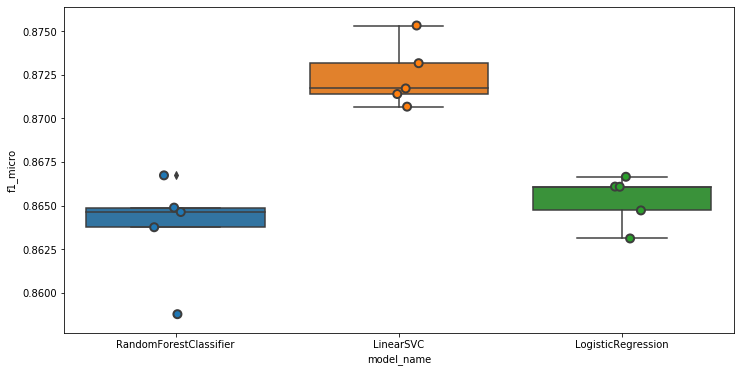

In [0]:
sns.boxplot(x='model_name', y='f1_micro', data=cv_df)
sns.stripplot(x='model_name', y='f1_micro', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

#### Since we are getting the best accuraxy in LinearSVC and LinearSVC doesn't take long time to give inference, we should use it as the final model and save the file for the web-service

In [0]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, data['Category'], data.index, 
                                                                                 test_size=0.2, random_state=0)
print(X_test)
print(y_test)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
6682                    BILL
44197                   BILL
2657                    BILL
51129          POLICY CHANGE
35114    CANCELLATION NOTICE
                ...         
34683          POLICY CHANGE
4706                    BILL
51725          POLICY CHANGE
49308          POLICY CHANGE
57075    CANCELLATION NOTICE
Name: Category, Length: 12441, dtype: object
0.870749939715457


In [0]:
X_test[4:5]

array([[0., 0., 0., ..., 0., 0., 0.]])

In [0]:
new_conf_mat = []
for i in range(len(conf_mat[0])):
    actual_value = sum(conf_mat[i])
    new_conf_mat.append([])
    for j in range(len(conf_mat[0])):
        val = conf_mat[i][j]
        new_conf_mat[i].append(val/actual_value * 100)
        
new_conf_mat = np.array(new_conf_mat)

#### There is still biased towards the majority class. New strategy should be implemented in future works to avoid this. We tried undersampling, but that didn't change the result. 

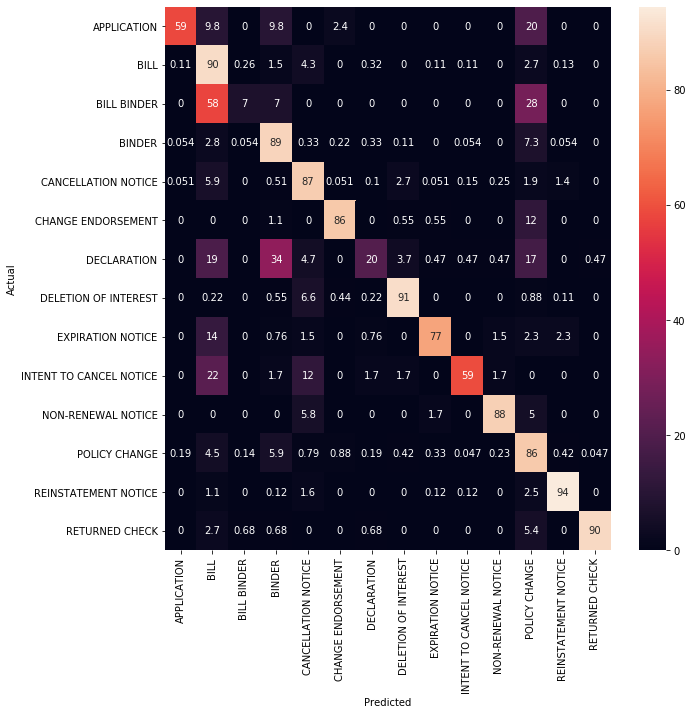

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
category_ids = data.groupby(['Category']).count().index
sns.heatmap(new_conf_mat, annot=True,
           xticklabels=category_ids, yticklabels=category_ids)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Creating the pipeline...

In [0]:
(features_train, labels_train) = (data.loc[:, 'Sentences'].values, data.loc[:, 'Category'])

tfidfv = TfidfVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=0.4, norm='l2')
selector = SelectKBest(chi2, k=1000)
linear_svc = LinearSVC()

calibrated_svc = CalibratedClassifierCV(linear_svc, method='sigmoid')

linearsvc = Pipeline([('vect', tfidfv),
                      ('selector', selector),
                      ('clf', calibrated_svc),
                      ])

linearsvc.fit(features_train, labels_train)
import joblib
joblib.dump(linearsvc, 'model_final.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['model_2.pkl']

In [0]:
!ls 

 AttentionModel.ipynb		   Sampling.ipynb
'baseline result on testdata'	   shuffled-full-set-hashed.csv
 color_tensorflow_real_mode.h5	   testdata
 HMM_Classification.ipynb	   Test_q2.xlsx
 images				   Train_q2.xlsx
 LSTM_Classifcation.ipynb	   Untitled0.ipynb
 lstm_classification_keras.ipynb   Untitled1.ipynb
 model_2.pkl			   Untitled2.ipynb
 model.json			   Untitled3.ipynb
 model.pkl			   Untitled4.ipynb
 Opencountry			   Untitled5.ipynb
